#### I've recieved permission to use 6 doccuments of anonymyzed data from IAA alumni, I'll read in that data and do some EDA

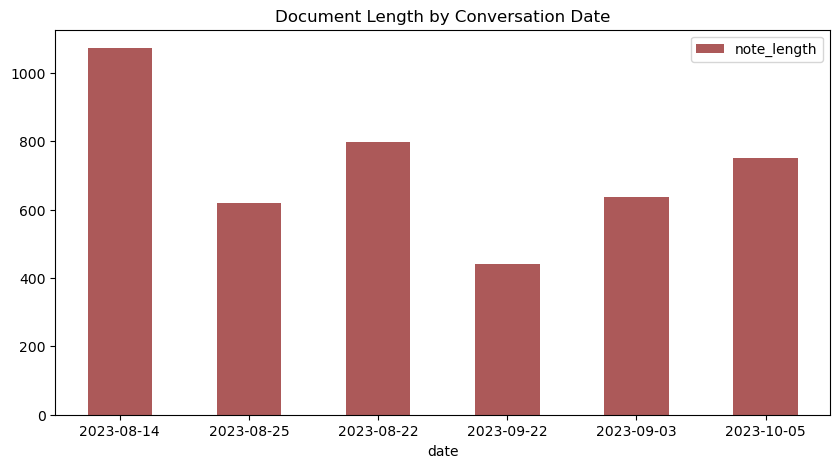

In [147]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from datetime import datetime



data = pd.read_csv("data.csv") # Load data

# Aside from the notes themselves, another attribut in the data is the date of the conversation. Maybe there's an association between the sentiment of the review and the date of the conversation.
note_length = []
for i in data.index:
    note_length.append(len(data.loc[i, 'notes'])) # adds a column for the note length
data['note_length'] = note_length # appends column to the dataframe

data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y') # Converts date column type to datetime 
data['date'] = data['date'].dt.date # drops the times

plot_df = data.drop('id', axis = 1)
plot_df.set_index('date').plot.bar(rot=0, figsize=(10, 5), alpha=0.65, color ='maroon')
plt.title('Document Length by Conversation Date')
plt.show() # Other than the document length, there isn't too much of interest, I'll move on to processing.


### The typical document length is around 400-600 words with a few exceptions. I'll move on to processing for analytics

[[1.         0.93686304 0.94849013 0.88507146 0.95839802 0.91771643]
 [0.93686304 1.         0.91677236 0.90929148 0.92009111 0.94621832]
 [0.94849013 0.91677236 1.         0.89275951 0.91202802 0.88164974]
 [0.88507146 0.90929148 0.89275951 1.         0.83046874 0.8663616 ]
 [0.95839802 0.92009111 0.91202802 0.83046874 1.         0.8997596 ]
 [0.91771643 0.94621832 0.88164974 0.8663616  0.8997596  1.        ]]


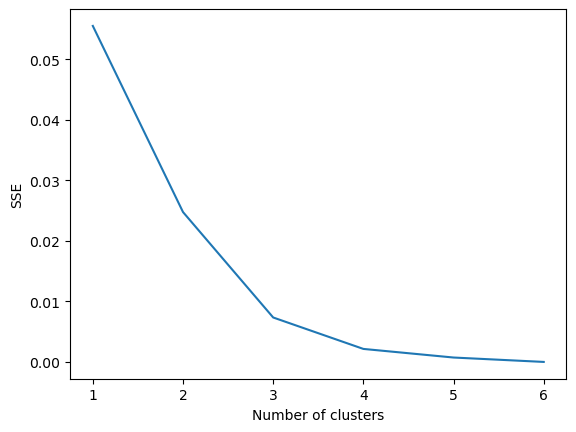

[[ 0.15913939 -0.01734454]
 [-0.05036736 -0.04101364]
 [-0.00401866  0.07019273]]
6


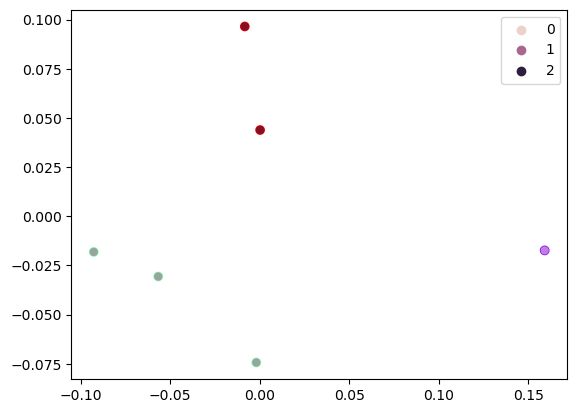

In [148]:
nlp = spacy.load('en_core_web_md')  # Loads CNN model

doc = list(data['notes']) # Isolating the documents


# Create initial NLP models of full document text

doc_nlp = []
for d in doc:
    doc_nlp.append(nlp(d))

# Strip punctuation, numbers, stop words

doc_strip = []
for i, d_nlp in enumerate(doc_nlp):
    doc_strip.append([tok.text for tok in d_nlp if (tok.is_alpha & (not tok.is_stop))])
    doc_strip[-1] = ' '.join(doc_strip[-1])

# Re-compute NLP on stripped documents

doc_strip_nlp = []
for d in doc_strip:
    doc_strip_nlp.append(nlp(d))

# Build similarity matrix

sim_mat = np.diag([1.0] * len(doc_strip_nlp))
for i in range(0, len(doc_strip_nlp) - 1):
    for j in range(i + 1, len(doc_strip_nlp)):
        sim_mat[i][j] = doc_strip_nlp[i].similarity(doc_strip_nlp[j])
        sim_mat[j][i] = sim_mat[i][j]

print(sim_mat) # Unsuprisingly, the documents are quite similar to eachother. 

# PCA and K Means clustering
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sim_mat) # PCA of similarity matrix
embeddings_df = pd.DataFrame({"x":embeddings_2d[:, 0], "y":embeddings_2d[:, 1]})
fig = px.scatter(embeddings_df, x='x', y='y', opacity=0.5)
fig.show()

# Elbow plot
sse = {}
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, max_iter=100, n_init=10).fit(embeddings_2d)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

# Creates clusters
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(embeddings_2d)

print(kmeans.cluster_centers_)

print(len(kmeans.labels_))

plt.scatter(embeddings_2d[:,0],embeddings_2d[:,1], c=kmeans.labels_, cmap="rainbow")
sns.scatterplot(data=embeddings_2d, x=embeddings_2d[:,0],y=embeddings_2d[:,1],
                hue=kmeans.labels_, linewidth=0, edgecolor="none",
                alpha = .6)

data = embeddings_2d
labels = kmeans.labels_
plt.show()